In [1]:
project_name = 'anime'

In [2]:
import os
data_dir = './anime_images'


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import os

In [4]:
image_size = 64
batch_size = 256
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)


In [5]:
train_ds = ImageFolder(data_dir,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]) )

train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=1,pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors *stats[1][0] +stats[0][0]

In [7]:
def show_images (images,nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl, nmax =64):
    for images, __ in dl:
        show_images(images,nmax)
        break

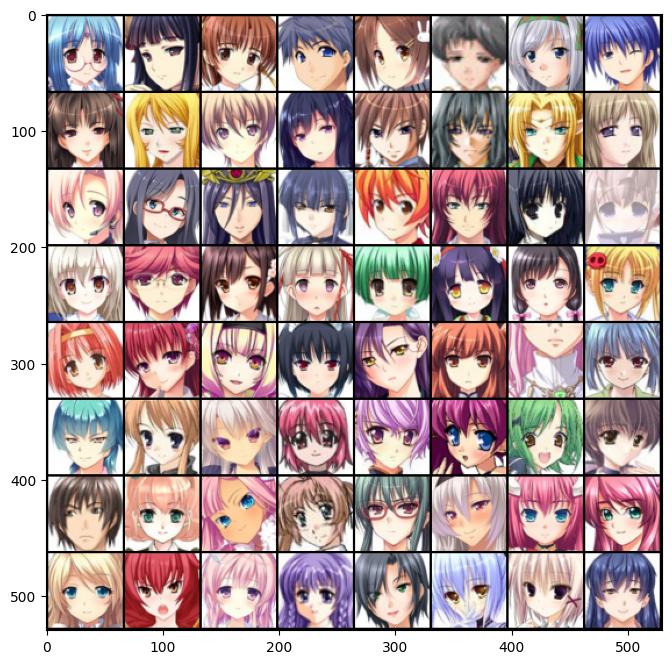

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device=get_default_device()
print(device)

cuda


In [11]:
train_dl = DeviceDataLoader(train_dl,device)

In [12]:
#develop discriminator

discriminator = nn.Sequential(

    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False), # 3x64x64 --> 64x32x32
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False), #64x32x32 --> 128x16x16 
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

    nn.Flatten(),
    nn.Sigmoid() #to classify into 1,0

)

In [13]:
discriminator = to_device(discriminator,device)

In [14]:
latent_size = 128

In [15]:
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False), #latent_sizex1x1 --> 512x4x4
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False), #512x4x4 --> 256x8x8
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False), 
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False), 
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False), #64x32x32 --> 3x64x64
    nn.Tanh() # convert in rance [-1,1]



)

In [16]:
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

torch.Size([256, 128, 1, 1])
torch.Size([256, 3, 64, 64])


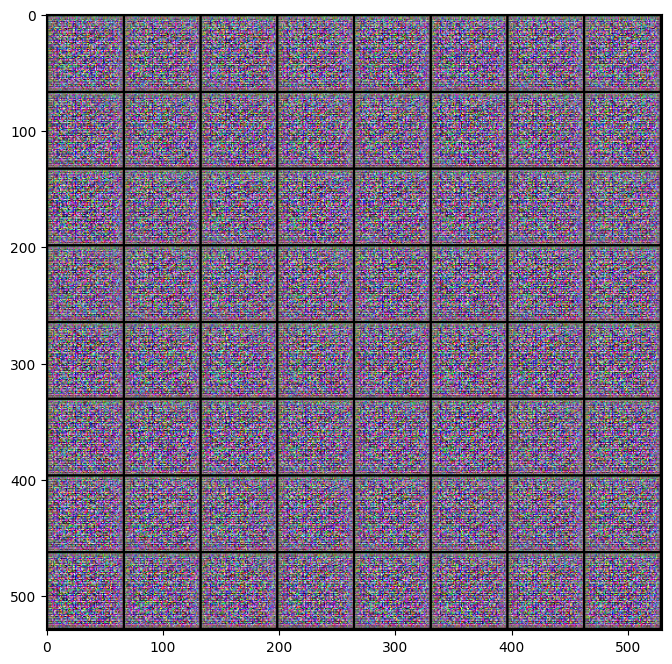

In [17]:
#generate random image
xb = torch.rand(batch_size,latent_size,1,1)
print(xb.shape)
fake_image = generator(xb)
print(fake_image.shape)
show_images(fake_image)

In [18]:
generator=to_device(generator,device)

In [19]:
def train_discriminator(real_images,opt_d):

    opt_d.zero_grad()
    #pass real img
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss= F.binary_cross_entropy(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()

    #generate fake image
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)
  
    #pass fake images
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(),real_score,fake_score

    

In [20]:
def train_generator(opt_g):

    opt_g.zero_grad()

    #generate fake images
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_image = generator(latent)

    #fool discriminator

    preds = discriminator(fake_image)
    targets = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds,targets)

    loss.backward()
    opt_g.step()
    return loss.item()


In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [23]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9997827..0.9999811].


Saving generated-images-0000.png


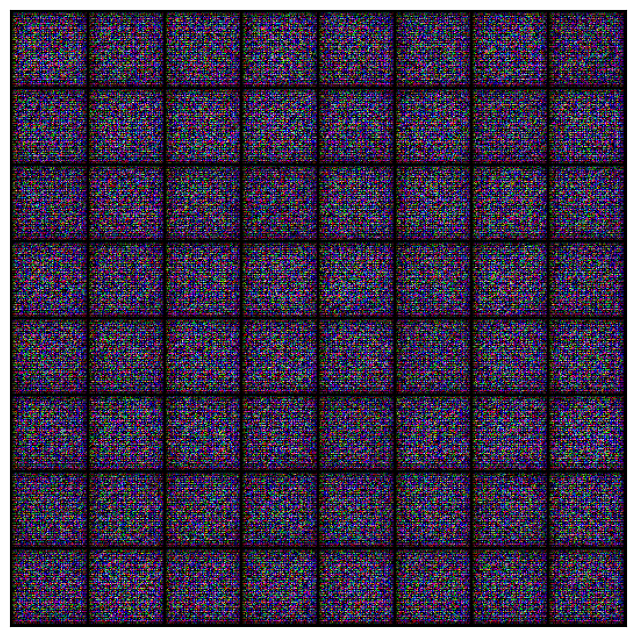

In [24]:
save_samples(0,fixed_latent)

In [25]:
def fit(epochs,lr,start_idx=1):
    torch.cuda.empty_cache()

    losses_g= []
    losses_d= []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas = (0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas = (0.5,0.999))

    for epoch in range(epochs):
        for real_images, __, in tqdm(train_dl):
            loss_d,real_score,fake_score = train_discriminator(real_images,opt_d)
            loss_g = train_generator(opt_g)
        
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print(f"epoch [{epoch+1}/{epochs}], loss_g: {loss_g} loss_d: {loss_d} real_score: {real_score} fake_score: {fake_score}")

        save_samples(epoch+start_idx,fixed_latent,show= False)
    return losses_g,losses_d,real_scores,fake_scores

In [26]:
lr = 0.0002
epochs = 15


In [27]:
history = fit(epochs,lr)

  0%|          | 0/249 [00:00<?, ?it/s]

epoch [1/15], loss_g: 3.6872291564941406 loss_d: 2.029775857925415 real_score: 0.21768490970134735 fake_score: 0.008949272334575653
Saving generated-images-0001.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [2/15], loss_g: 3.79364013671875 loss_d: 0.814834475517273 real_score: 0.5421612858772278 fake_score: 0.029954396188259125
Saving generated-images-0002.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [3/15], loss_g: 4.1116743087768555 loss_d: 0.4878215789794922 real_score: 0.7435424327850342 fake_score: 0.09321650117635727
Saving generated-images-0003.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [4/15], loss_g: 5.923933506011963 loss_d: 0.3894645571708679 real_score: 0.8980229496955872 fake_score: 0.22964423894882202
Saving generated-images-0004.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [5/15], loss_g: 4.212640762329102 loss_d: 0.3208722770214081 real_score: 0.8169271349906921 fake_score: 0.07650959491729736
Saving generated-images-0005.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [6/15], loss_g: 5.903712272644043 loss_d: 0.42283326387405396 real_score: 0.8976956605911255 fake_score: 0.24948126077651978
Saving generated-images-0006.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [7/15], loss_g: 3.774219036102295 loss_d: 0.3123190999031067 real_score: 0.8562709093093872 fake_score: 0.11655192077159882
Saving generated-images-0007.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [8/15], loss_g: 4.127825736999512 loss_d: 0.841198205947876 real_score: 0.5275372862815857 fake_score: 0.007398630492389202
Saving generated-images-0008.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [9/15], loss_g: 8.955972671508789 loss_d: 0.6600667238235474 real_score: 0.9100416302680969 fake_score: 0.3873779773712158
Saving generated-images-0009.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [10/15], loss_g: 6.180822372436523 loss_d: 0.3224189281463623 real_score: 0.9266329407691956 fake_score: 0.19705644249916077
Saving generated-images-0010.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [11/15], loss_g: 1.7213413715362549 loss_d: 1.8876582384109497 real_score: 0.25727543234825134 fake_score: 0.0019784588366746902
Saving generated-images-0011.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [12/15], loss_g: 3.5761523246765137 loss_d: 0.11078334599733353 real_score: 0.9498633742332458 fake_score: 0.053404830396175385
Saving generated-images-0012.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [13/15], loss_g: 3.2986016273498535 loss_d: 0.3430978059768677 real_score: 0.7893673181533813 fake_score: 0.053854890167713165
Saving generated-images-0013.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [14/15], loss_g: 4.446688652038574 loss_d: 0.28659960627555847 real_score: 0.8758695721626282 fake_score: 0.12147152423858643
Saving generated-images-0014.png


  0%|          | 0/249 [00:00<?, ?it/s]

epoch [15/15], loss_g: 5.407668590545654 loss_d: 0.23104164004325867 real_score: 0.9634679555892944 fake_score: 0.163272887468338
Saving generated-images-0015.png


In [28]:
losses_g, losses_d, real_scores, fake_scores = history

In [29]:
torch.save(generator.state_dict(),'Generator.ckpt')
torch.save(discriminator.state_dict(),'Discriminator.ckpt')

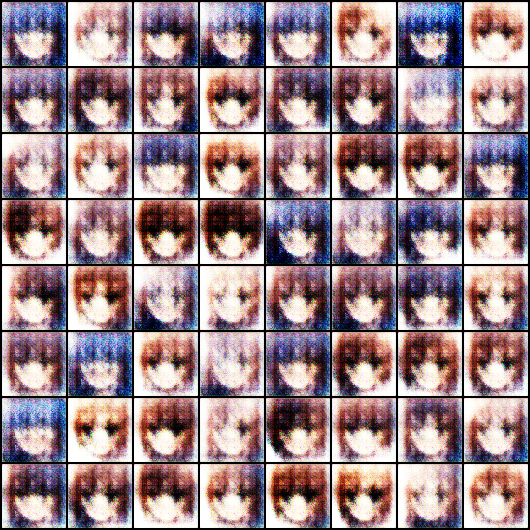

In [30]:
from IPython.display import Image
Image('./generated/generated-images-0001.png')


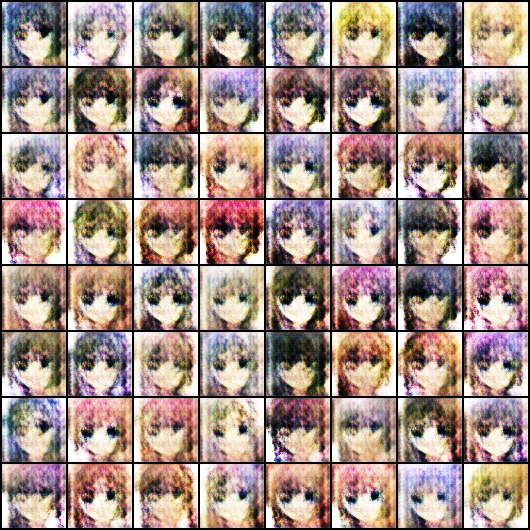

In [31]:
Image('./generated/generated-images-0002.png')


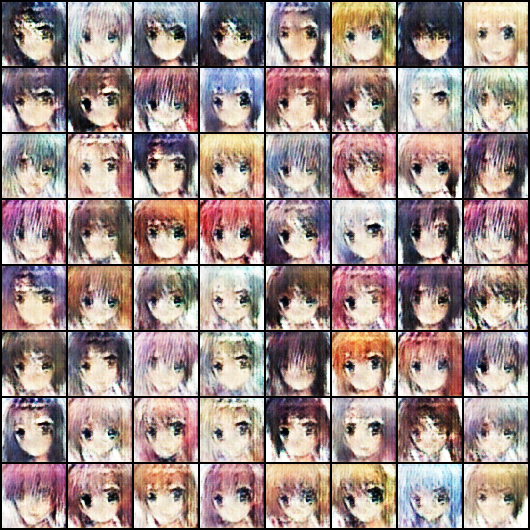

In [32]:
Image('./generated/generated-images-0006.png')


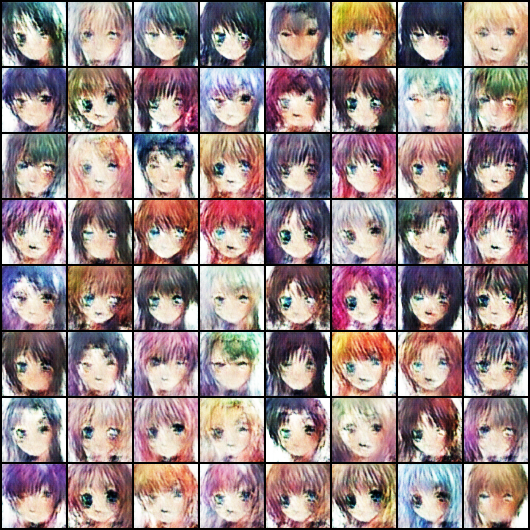

In [33]:
Image('./generated/generated-images-0008.png')


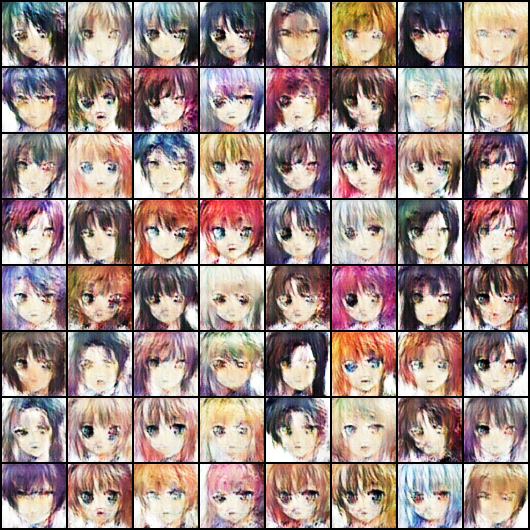

In [34]:
Image('./generated/generated-images-0009.png')


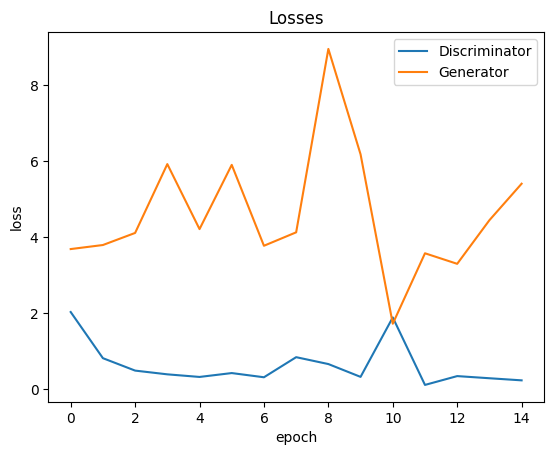

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

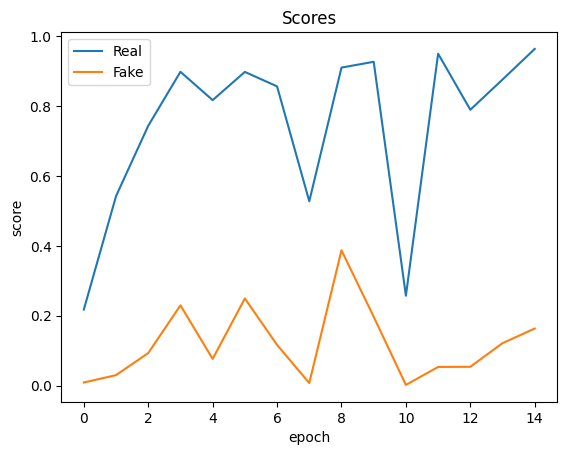

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')